<a href="https://colab.research.google.com/github/SerafinCarba/Ejercicio-mejora-rendimiento-redes-neuronales/blob/master/Copia_de_improving_neural_net_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Mejora del rendimiento de las redes neuronales

 **Objetivo de aprendizaje:** mejorar el rendimiento de una red neuronal al normalizar los atributos y aplicar diversos algoritmos de optimización

**NOTA:** Los métodos de optimización que se describen en este ejercicio no son específicos para las redes neuronales; son medios eficaces para mejorar la mayoría de los tipos de modelos.

 ## Preparación

Primero, cargaremos los datos.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [0]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2646.4,539.5,1431.8,501.5,3.9,2.0
std,2.1,2.0,12.7,2183.4,423.5,1164.7,386.8,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1462.8,296.0,791.8,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.5,435.0,1169.5,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3155.0,648.0,1722.0,605.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.3,2637.1,539.1,1424.3,500.5,3.9,2.0
std,2.2,2.0,12.4,2171.8,416.6,1106.6,379.1,1.9,1.2
min,32.6,-124.3,1.0,15.0,3.0,8.0,4.0,0.5,0.2
25%,33.9,-121.8,18.0,1461.8,298.0,786.0,282.0,2.5,1.5
50%,34.3,-118.5,28.0,2122.0,431.0,1160.5,404.0,3.5,1.9
75%,37.7,-118.0,37.0,3137.2,649.2,1718.0,606.0,4.8,2.3
max,41.9,-114.6,52.0,37937.0,5471.0,16122.0,5189.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,208.2
std,116.7
min,15.0
25%,120.0
50%,180.4
75%,266.0
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,205.1
std,114.2
min,15.0
25%,118.8
50%,180.1
75%,262.5
max,500.0


 ## Entrenamiento de la red neuronal

A continuación, entrenaremos la red neuronal.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 154.63
  period 01 : 145.02
  period 02 : 132.49
  period 03 : 117.24
  period 04 : 112.10
  period 05 : 106.23
  period 06 : 107.15
  period 07 : 103.41
  period 08 : 105.15
  period 09 : 109.32
Model training finished.
Final RMSE (on training data):   109.32
Final RMSE (on validation data): 106.77


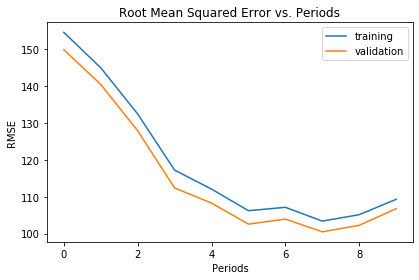

In [0]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Ajuste lineal
Una buena práctica estándar puede ser normalizar las entradas para que estén dentro del rango -1, 1. Esto ayuda al SGD a no bloquearse al realizar pasos que son demasiado grandes en una dimensión o demasiado pequeños en otra. Los apasionados de la optimización numérica pueden observar aquí una relación con la idea de usar un precondicionador.

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

 ## Tarea 1: Normalizar los atributos con ajuste lineal
**Normaliza las entradas a la escala -1, 1.**
**Dedica alrededor de 5 minutos a entrenar y evaluar los datos recientemente normalizados. ¿Qué nivel de eficacia puedes tener?**
Como regla general, las redes neuronales se entrenan mejor cuando los atributos de entrada están casi en la misma escala.
Realiza una comprobación de estado de tus datos normalizados. (¿Qué ocurriría si olvidaras normalizar un atributo?)


Training model...
RMSE (on training data):
  period 00 : 159.82
  period 01 : 114.01
  period 02 : 101.61
  period 03 : 84.89
  period 04 : 77.42
  period 05 : 75.06
  period 06 : 73.60
  period 07 : 72.55
  period 08 : 72.45
  period 09 : 71.48
Model training finished.
Final RMSE (on training data):   71.48
Final RMSE (on validation data): 68.34
Training model...
RMSE (on training data):
  period 00 : 229.88
  period 01 : 203.17
  period 02 : 153.14
  period 03 : 117.77
  period 04 : 113.79
  period 05 : 109.60
  period 06 : 104.52
  period 07 : 98.52
  period 08 : 91.95
  period 09 : 85.50
Model training finished.
Final RMSE (on training data):   85.50
Final RMSE (on validation data): 82.39


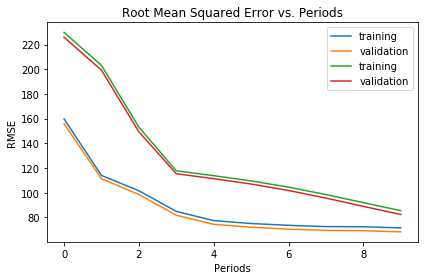

In [0]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

pass

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ### Solución

Haz clic más abajo para conocer una solución posible.

 Dado que la normalización usa mín. y máx., debemos asegurarnos de que esta se realice en todo el conjunto de datos a la vez.

En este caso podemos hacerlo, porque todos nuestros datos están en un mismo DataFrame. Si tuviéramos varios conjuntos de datos, una buena práctica sería derivar los parámetros de normalización del conjunto de entrenamiento y aplicarlos de manera idéntica al conjunto de prueba.

In [0]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## Tarea 2: Probar un optimizador diferente

** Usa los optmizadores AdaGrad y Adam, y compara el rendimiento.**

El optimizador AdaGrad es una alternativa. La idea clave de AdaGrad es que modifica la tasa de aprendizaje de forma adaptativa para cada coeficiente de un modelo, lo cual disminuye la tasa de aprendizaje efectiva de forma monótona. Esto funciona muy bien para los problemas convexos, pero no siempre resulta ideal para el entrenamiento de redes neuronales con problemas no convexos. Puedes usar AdaGrad al especificar `AdagradOptimizer` en lugar de `GradientDescentOptimizer`. Ten en cuenta que, con AdaGrad, es posible que debas usar una tasa de aprendizaje más alta.

Para los problemas de optimización no convexos, en algunas ocasiones Adam es más eficaz que AdaGrad. Para usar Adam, invoca el método `tf.train.AdamOptimizer`. Este método toma varios hiperparámetros opcionales como argumentos, pero nuestra solución solo especifica uno de estos (`learning_rate`). En un entorno de producción, debes especificar y ajustar los hiperparámetros opcionales con cuidado.

Training model...
RMSE (on training data):
  period 00 : 86.29
  period 01 : 82.46
  period 02 : 73.87
  period 03 : 75.75
  period 04 : 70.86
  period 05 : 71.33
  period 06 : 70.70
  period 07 : 71.35
  period 08 : 70.24
  period 09 : 71.35
Model training finished.
Final RMSE (on training data):   71.35
Final RMSE (on validation data): 68.83
Training model...
RMSE (on training data):
  period 00 : 221.73
  period 01 : 144.65
  period 02 : 118.80
  period 03 : 113.97
  period 04 : 107.40
  period 05 : 96.20
  period 06 : 83.79
  period 07 : 74.49
  period 08 : 72.50
  period 09 : 71.82
Model training finished.
Final RMSE (on training data):   71.82
Final RMSE (on validation data): 68.78


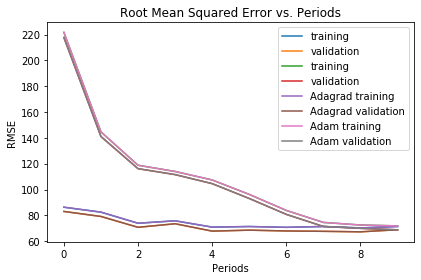

In [0]:
#
# YOUR CODE HERE: Retrain the network using Adagrad and then Adam.

"""Probamos con AdaGrad. Mejor para problemas convexos"""
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

"""Prueba con Adam. Mejor para problemas no convexos"""

_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

"""Imprimimos un gráfico de perdidas comparando AdadGrad con Adam"""

plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()




 ### Solución

Haz clic más abajo para conocer la solución.

 Primero, probemos AdaGrad.

In [0]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 Ahora, probemos Adam.

In [0]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 Imprimamos un gráfico de métricas de pérdida en paralelo.

In [0]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

 ## Tarea 3: Explorar métodos de normalización alternativos

**Prueba alternar las normalizaciones para distintos atributos a fin de mejorar aún más el rendimiento.**

Si observas detenidamente las estadísticas de resumen de los datos transformados, es posible que observes que, al realizar un ajuste lineal en algunos atributos, estos quedan agrupados cerca de `-1`.

Por ejemplo, muchos atributos tienen una mediana de alrededor de `-0.8`, en lugar de `0.0`.

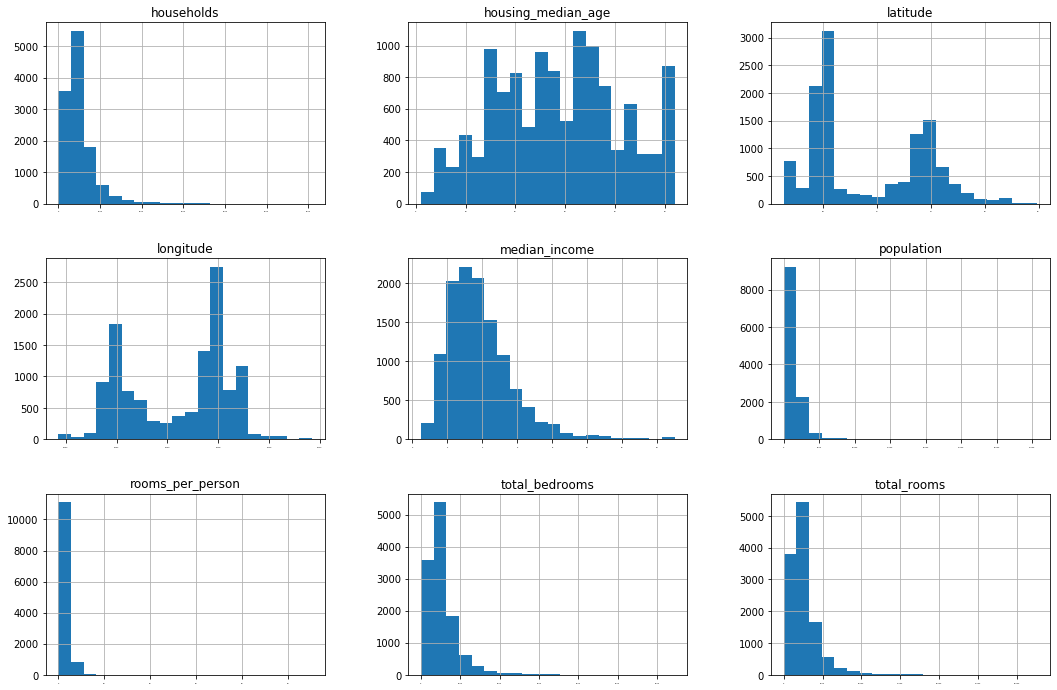

In [0]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=2)

 Es posible que obtengamos mejores resultados al elegir formas adicionales para transformar estos atributos.

Por ejemplo, un ajuste logarítmico podría ayudar a algunos atributos. O bien, el recorte de los valores extremos podría hacer que el resto del ajuste sea más informativo.

In [0]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

 El bloque anterior contiene algunas funciones de normalización adicionales posibles. Prueba algunas de estas o agrega otras propias.

Ten en cuenta que, si normalizas el objetivo, deberás anular la normalización de las predicciones para que las métricas de pérdida sean comparables.

Training model...
RMSE (on training data):
  period 00 : 97.85
  period 01 : 80.88
  period 02 : 78.10
  period 03 : 76.24
  period 04 : 75.08
  period 05 : 74.34
  period 06 : 72.88
  period 07 : 72.18
  period 08 : 71.55
  period 09 : 71.45
Model training finished.
Final RMSE (on training data):   71.45
Final RMSE (on validation data): 68.01
Training model...
RMSE (on training data):
  period 00 : 220.59
  period 01 : 150.37
  period 02 : 116.55
  period 03 : 114.98
  period 04 : 113.30
  period 05 : 111.24
  period 06 : 108.61
  period 07 : 105.13
  period 08 : 100.70
  period 09 : 95.66
Model training finished.
Final RMSE (on training data):   95.66
Final RMSE (on validation data): 92.59


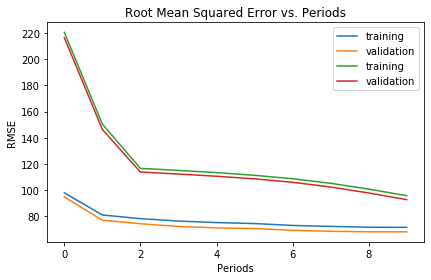

In [0]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  #
  # YOUR CODE HERE: Normalize the inputs.
  """Las funciones households, median_income y total_bedrooms aparecen todas distribuidas normalmente en un espacio logarítmico.
Las funciones latitude, longitude y housing_median_age probablemente serían mejores si solamente se ajustaran de forma lineal, como antes.
Las funciones population, totalRooms y rooms_per_person tienen algunos valores atípicos extremos. Parecen ser demasiado extremos como para que la normalización logarítmica resulte útil. Por lo tanto, los recortaremos en su lugar."""

def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

  #
pass

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ### Solución

Haz clic más abajo para conocer una solución posible.

 Estas son solo algunas formas en las que podemos pensar acerca de los datos. Otras transformaciones podrían funcionar incluso mejor.

Las funciones `households`, `median_income` y `total_bedrooms` aparecen todas distribuidas normalmente en un espacio logarítmico.

Las funciones `latitude`, `longitude` y `housing_median_age` probablemente serían mejores si solamente se ajustaran de forma lineal, como antes.

Las funciones `population`, `totalRooms` y `rooms_per_person` tienen algunos valores atípicos extremos. Parecen ser demasiado extremos como para que la normalización logarítmica resulte útil. Por lo tanto, los recortaremos en su lugar.

In [0]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## Desafío opcional: Usar solo los atributos de latitud y longitud

**Entrena un modelo de red neuronal que use solo latitud y longitud como atributos.**

A los agentes de bienes raíces les gusta decir que la ubicación es el único atributo importante en el precio de la vivienda.
Veamos si podemos confirmar esto al entrenar un modelo que use solo latitud y longitud como atributos.

Esto funcionará bien únicamente si nuestra red neuronal puede aprender no linealidades complejas a partir de la latitud y la longitud.

**NOTA:** Es posible que necesitemos una estructura de red que tenga más capas que las que eran útiles anteriormente en el ejercicio.

Training model...
RMSE (on training data):
  period 00 : 115.99
  period 01 : 106.51
  period 02 : 104.96
  period 03 : 103.30
  period 04 : 103.42
  period 05 : 102.26
  period 06 : 101.76
  period 07 : 101.63
  period 08 : 101.56
  period 09 : 100.82
Model training finished.
Final RMSE (on training data):   100.82
Final RMSE (on validation data): 98.04


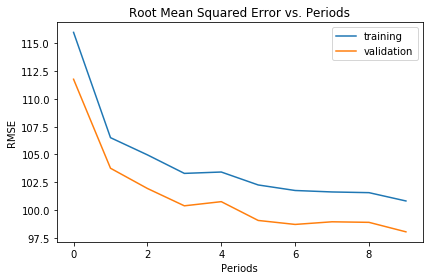

In [0]:
#
# YOUR CODE HERE: Train the network using only latitude and longitude

def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)

#

 ### Solución

Haz clic más abajo para conocer una solución posible.

 Una buena idea es mantener latitud y longitud normalizadas:

In [0]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)

 Esto no es tan malo para solo dos funciones. De todos modos, los valores de la propiedad pueden variar en distancias cortas.